In [ ]:
!pip install python-crfsuite
!pip install sklearn-crfsuite

In [ ]:
def load_data(file):
    # Opening file 
    f = open(file, 'r') 
    sents = []
    sent = []
    for line in f:
        cur_line = line.strip()
        if not cur_line:
            sents.append(sent)
            sent = []
        else:
            cur_line_list = cur_line.split(" ")
            cur_line_list[2] = cur_line_list[2][0]
            sent.append(cur_line_list)
    return sents

In [ ]:
train_sents = load_data('/content/train.txt')

In [ ]:
print(train_sents)

In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

###Feature design

In [ ]:
# Will be updated
# w is window size
def word2features(sent, i, w=2):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    for k in range(1,w+1):
      if i-k >= 0:
        word1 = sent[i-k][0]
        postag1 = sent[i-k][1]
        features.update({
            f'-{k}:word.lower()': word1.lower(),
            f'-{k}:word.istitle()': word1.istitle(),
            f'-{k}:word.isupper()': word1.isupper(),
            f'-{k}:postag': postag1,
            f'-{k}:postag[:2]': postag1[:2],
        })
    if i==0:
        features['BOS'] = True
    for k in range(1,w+1):
      if i+k <= len(sent)-1:
        word1 = sent[i+k][0]
        postag1 = sent[i+k][1]
        features.update({
            f'+{k}:word.lower()': word1.lower(),
            f'+{k}:word.istitle()': word1.istitle(),
            f'+{k}:word.isupper()': word1.isupper(),
            f'+{k}:postag': postag1,
            f'+{k}:postag[:2]': postag1[:2],
        })
    if i== len(sent)-1:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

#Train data

In [ ]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.5,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.5, c2=0.5, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
labels = list(crf.classes_)
print(labels)
labels.remove('O')
print(labels)

['B', 'I', 'O']
['B', 'I']


In [ ]:
y_pred = crf.predict(X_train)
metrics.flat_f1_score(y_train, y_pred,average='weighted', labels=labels)

0.9678807397255166

In [ ]:
print(metrics.flat_classification_report(
    y_train, y_pred, digits=3))

              precision    recall  f1-score   support

           B      0.974     0.972     0.973    106978
           I      0.959     0.963     0.961     76847
           O      0.976     0.972     0.974     27902

    accuracy                          0.969    211727
   macro avg      0.969     0.969     0.969    211727
weighted avg      0.969     0.969     0.969    211727



#Test data

In [ ]:
test_sents = load_data('/content/test.txt')
X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,average='weighted', labels=labels)

0.9519020953937176

In [ ]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3))

              precision    recall  f1-score   support

           B      0.963     0.959     0.961     23852
           I      0.938     0.942     0.940     17345

   micro avg      0.952     0.952     0.952     41197
   macro avg      0.950     0.950     0.950     41197
weighted avg      0.952     0.952     0.952     41197



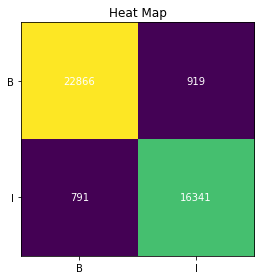

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
%matplotlib inline
y_test_flattened = []
for i in y_test:
  for j in i:
    y_test_flattened.append(j)
y_pred_flattened = []
for i in y_pred:
  for j in i:
    y_pred_flattened.append(j)
conf_matr = confusion_matrix(y_test_flattened, y_pred_flattened, labels=labels)
fig, ax = plt.subplots()
im = ax.imshow(conf_matr)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)


for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, conf_matr[i,j],
                       ha="center", va="center", color="w")

ax.set_title("Heat Map")
fig.tight_layout()
plt.show()

#Error analysis

In [ ]:
# Find incorrectly chunked sents (with pos tag)
sent_words = [sent2tokens(s) for s in test_sents]
count = 0
for i in range(len(y_test)):
  if y_test[i] != y_pred[i] and count < 100:
    count += 1
    print(i)
    print('Actual chunk labels: {}'.format(y_test[i]))
    print('Predicted chunk labels: {}'.format(y_pred[i]))
    print('Sentence: {}'.format(test_sents[i]))

2
Actual chunk labels: ['B', 'B', 'O', 'B', 'B', 'I', 'O', 'B', 'I', 'B', 'I', 'I', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'I', 'O', 'B', 'I', 'I', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'O']
Predicted chunk labels: ['B', 'I', 'O', 'B', 'B', 'I', 'O', 'B', 'I', 'B', 'I', 'I', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'B', 'O', 'B', 'I', 'I', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'O']
Sentence: [['These', 'DT', 'B'], ['include', 'VBP', 'B'], [',', ',', 'O'], ['among', 'IN', 'B'], ['other', 'JJ', 'B'], ['parts', 'NNS', 'I'], [',', ',', 'O'], ['each', 'DT', 'B'], ['jetliner', 'NN', 'I'], ["'s", 'POS', 'B'], ['two', 'CD', 'I'], ['major', 'JJ', 'I'], ['bulkheads', 'NNS', 'I'], [',', ',', 'O'], ['a', 'DT', 'B'], ['pressure', 'NN', 'I'], ['floor', 'NN', 'I'], [',', ',', 'O'], ['torque', 'NN', 'B'], ['box', 'NN', 'I'], [',', ',', 'O'], ['fixed', 'VBN', 'B'], ['leading', 'VBG', 'I'], ['edges', 'NNS', 'I'], ['for', 'IN', 'B'], ['the', 'DT', 'B'], ['wings', 'NNS', 'I'], ['and', 'CC', 'O'], ['an', 'DT', '

In [ ]:
# Find incorrectly chunked sents (without pos tag)
sent_words = [sent2tokens(s) for s in test_sents]
count = 0
for i in range(len(y_test)):
  if y_test[i] != y_pred[i] and count < 100:
    count += 1
    print(i)
    print('Actual chunk labels: {}'.format(y_test[i]))
    print('Predicted chunk labels: {}'.format(y_pred[i]))
    print('Sentence: {}'.format(test_sents[i]))

1
Actual chunk labels: ['B', 'B', 'B', 'I', 'B', 'B', 'B', 'B', 'I', 'B', 'I', 'I', 'I', 'B', 'B', 'I', 'O']
Predicted chunk labels: ['B', 'B', 'B', 'I', 'B', 'B', 'B', 'B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I', 'O']
Sentence: [['Rockwell', 'NNP', 'B'], ['said', 'VBD', 'B'], ['the', 'DT', 'B'], ['agreement', 'NN', 'I'], ['calls', 'VBZ', 'B'], ['for', 'IN', 'B'], ['it', 'PRP', 'B'], ['to', 'TO', 'B'], ['supply', 'VB', 'I'], ['200', 'CD', 'B'], ['additional', 'JJ', 'I'], ['so-called', 'JJ', 'I'], ['shipsets', 'NNS', 'I'], ['for', 'IN', 'B'], ['the', 'DT', 'B'], ['planes', 'NNS', 'I'], ['.', '.', 'O']]
2
Actual chunk labels: ['B', 'B', 'O', 'B', 'B', 'I', 'O', 'B', 'I', 'B', 'I', 'I', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'I', 'O', 'B', 'I', 'I', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'O']
Predicted chunk labels: ['B', 'I', 'O', 'B', 'B', 'I', 'O', 'B', 'I', 'B', 'I', 'I', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'B', 'O', 'B', 'I', 'I', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'O']
Sentence: [[

In [ ]:
count = 0
total = 0
for s in train_sents:
  for w in s:
    if w[1] == 'CD':
      count += 1
    total += 1
print(count, total)

8315 211727


In [ ]:
print(" ".join(sent_words[1]), " ".join(sent_words[3]), " ".join(sent_words[101]))

Rockwell said the agreement calls for it to supply 200 additional so-called shipsets for the planes . Under the existing contract , Rockwell said , it has already delivered 793 of the shipsets to Boeing . To focus on its global consumer-products business , Colgate sold its Kendall health-care business in 1988 .
